In [2]:
from igraph import Graph
import pandas as pd
import igraph
import networkx as nx

In [3]:
nodes=pd.read_csv('Nodes_df4.csv')
edges=pd.read_csv('Edges_df4.csv')

#### Individuiamo il Giant Component

In [4]:
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))


In [5]:
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [26]:
#codice per identificare giant component
nodes['Giant_Component']=0

colour=[]
for index in largest_component:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Giant_Component']=1
    else:
        continue

#### Applichiamo leading eigenvector

In [27]:
eigen=new_g.community_leading_eigenvector(2)
eigen.summary()

C:\ProgramData\Anaconda3\lib\site-packages\igraph\__init__.py:1281: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:530
  membership, _, q = GraphBase.community_leading_eigenvector(


'Clustering with 3527 elements and 2 clusters'

In [28]:
eigen_nodes=eigen.graph.vs["name"]
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

In [29]:
df_eigen

,nodes,clusters
0,2279301,0
1,5253961,0
2,5718002,1
3,6012422,0
4,6243422,0
...,...,...
3522,1474895624843800581,0
3523,1475049574809186307,0
3524,1475122883164876805,0
3525,1475496660268638210,0


<AxesSubplot:>

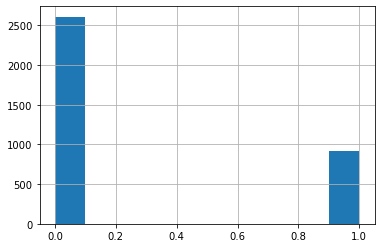

In [30]:
df_eigen["clusters"].hist()

In [31]:
df_eigen.groupby("clusters")["clusters"].count()

clusters
0    2608
1     919
Name: clusters, dtype: int64

In [32]:
def color_clusters(cluster_df,cluster_field,new_cluster_field_name):
    clusters=list(set(cluster_df[cluster_field]))
    nodes[new_cluster_field_name]=0

    for index, row in cluster_df.iterrows():
        subset=nodes[nodes.Id==int(row['nodes'])]
        if subset.empty == False:
            sub_index=subset.index
            for cluster in clusters:
                if row['clusters']==cluster:
                    nodes.at[sub_index,new_cluster_field_name]=cluster+1
        else:
            continue

In [34]:
color_clusters(df_eigen,'clusters','cluster_eigen')

In [8]:
#clusters=list(set(df_eigen.clusters))
#nodes['Cluster_eigen']=0
#
#colour=[]
#for index, row in df_eigen.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        for cluster in clusters:
#            if row['clusters']==cluster:
#                nodes.at[sub_index,'Cluster_eigen']=cluster+1
#    else:
#        continue

In [33]:
#utile solo nel caso che il dataframe di partenza presenti gli hex colors invece dei cluster

#for i,r in dummy.iterrows():
#    if r['Colour']=='#aaaacc':
#        dummy.at[i,'Colour']=0
#    if r['Colour']=='#007474':
#        dummy.at[i,'Colour']=1
#    if r['Colour']=='#fb1239':
#        dummy.at[i,'Colour']=2

#### Creazione indice e applicazione k-means

In [36]:
contiguous_nodes_dict={}

for node in nodes.Id:
    lista_target=list(new_edges[new_edges.Source==node]['Target'])
    lista_source=list(new_edges[new_edges.Target==node]['Source'])
    lista_tot=lista_target+lista_source
    if lista_tot != []:
        contiguous_nodes_dict[node]=lista_tot

In [37]:
def Jaccard(nodesA,nodesB):
    intersect = [value for value in nodesA if value in nodesB]
    union=list(set(nodesA+nodesB))
    compute_jaccard=len(intersect)/len(union)
    return compute_jaccard

In [38]:
distance_matrix_j=[[ Jaccard(values_col,values_row) for values_row in contiguous_nodes_dict.values()] for values_col in contiguous_nodes_dict.values()]

In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000,algorithm="elkan").fit(distance_matrix_j)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

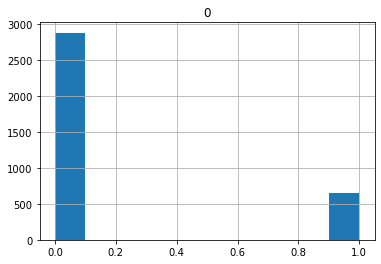

In [40]:
pd.DataFrame(kmeans.labels_).hist()

In [41]:
df_means=pd.DataFrame({'nodes':contiguous_nodes_dict.keys(),'clusters':kmeans.labels_})

In [46]:
color_clusters(df_means,'clusters','cluster_kmeans')

In [47]:
nodes.to_csv("nodes_provvisorio.csv")

In [378]:
#nodes['Colour']='#aaaacc'
#
#colour=[]
#for index, row in df_means.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        if row['clusters']==0:
#            nodes.at[sub_index,'Colour']='1'
#        if row['clusters']==1:
#            nodes.at[sub_index,'Colour']='2'
#    else:
#        continue

#### Modularity maximization

In [130]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [131]:
new_G=new_G.to_undirected()

In [132]:
from networkx.algorithms.community import modularity_max
c = list(modularity_max.greedy_modularity_communities(new_G))

In [456]:
nodes['Cluster_mod']='#aaaacc'

colours_list=list(range(0,24))
i=0
for community in c:
    colour=[]
    for node in list(community):
        subset=nodes[nodes.Id==int(node)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Cluster_mod']=colours_list[i]
        else:
            continue
    i+=1

#### Girvan-Newman

In [414]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [415]:
new_G=new_G.to_undirected()

In [397]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [398]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [416]:
# find communities in the graph
c = girvan_newman(new_G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

In [417]:
nodes['Colour_GN']=0

for group in range(0,len(node_groups)):
    for idx in node_groups[group]:
        subset=nodes[nodes.Id==int(idx)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Colour_GN']=group+1
        else:
            continue

In [418]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)

#### Valutazione Grafo

In [6]:
#creazione grafo in networkx della Giant Component
G_nx=nx.from_pandas_edgelist(new_edges,source='Source',target='Target')

Assortativity

In [7]:
#Assortativity per intero grafo
#nx.degree_assortativity_coefficient(g_nx)
nx.degree_pearson_correlation_coefficient(g_nx) #più veloce

-0.3604330966037621

In [60]:
#Assortativity per la sola giant component
nx.degree_pearson_correlation_coefficient(G_nx)

-0.37425282150701356

La nostra rete è quindi disassortativa:
- Hubs tend to connect to small nodes.
- Disassortative networks have difficulty forming a giant
component (ops? ahahah)
- Hub removal is more damaging in disassortative networks, as in these the
hubs connect to many small-degree nodes, which fall off the network
once a hub is deleted.

Degree

In [14]:
nx.degree_mixing_dict(g_nx) #cos'è??

{888: {1: 527,
  4: 50,
  2: 183,
  5: 17,
  7: 4,
  3: 83,
  6: 11,
  30: 1,
  18: 1,
  10: 1,
  8: 4,
  9: 1,
  12: 1,
  13: 1,
  11: 2,
  20: 1},
 1: {888: 527,
  111: 42,
  20: 18,
  12: 36,
  148: 39,
  324: 178,
  579: 500,
  235: 187,
  7: 19,
  30: 10,
  207: 67,
  188: 81,
  2: 51,
  14: 20,
  426: 331,
  11: 33,
  87: 70,
  8: 30,
  1: 118,
  51: 21,
  3: 37,
  13: 15,
  56: 24,
  10: 5,
  29: 6,
  6: 35,
  40: 18,
  42: 46,
  18: 27,
  35: 15,
  4: 30,
  86: 35,
  5: 21,
  26: 11,
  63: 38,
  92: 27,
  28: 18,
  16: 5,
  25: 12,
  9: 13,
  19: 2,
  15: 6},
 4: {888: 50,
  324: 17,
  40: 6,
  7: 5,
  15: 12,
  13: 4,
  86: 10,
  5: 8,
  51: 2,
  148: 20,
  2: 20,
  426: 4,
  87: 1,
  579: 2,
  19: 5,
  1: 30,
  4: 10,
  6: 6,
  188: 16,
  207: 23,
  111: 12,
  3: 9,
  63: 1,
  8: 9,
  14: 1,
  42: 2,
  235: 1,
  18: 2,
  35: 1,
  11: 4,
  29: 7,
  92: 11,
  12: 3,
  20: 7,
  56: 2,
  16: 1,
  10: 1,
  30: 3,
  9: 1,
  26: 1},
 2: {20: 17,
  86: 14,
  888: 183,
  188: 47,
  6:

In [19]:
nx.out_degree_centrality(g_nx)

NetworkXNotImplemented: not implemented for undirected type

In [74]:
#Connectivity measures the minimum number of elements (vertices or edges) that must be removed to disconnect the graph
nx.edge_connectivity(g_nx)

0

In [75]:
nx.edge_connectivity(G_nx)

1

##### Percolation?

In [71]:
#nx.percolation.percolation_centrality